# Data project

**Project discription** 

In this project we examin the relationship between the expenditure in danish municipalities and the number of books are boaroed during the year. We expect a positive relationship. That being said. We do not claim to have identified a causal relationship.


**Data and variables**

We use data from Statistics Denmark. We use the dataset BIB1 which contains data on libraries, by municipalities and the dataset FOLK1A which contains data on the number of people living in each municipalities 
Udlån 



**Table of contents**<a id='toc0_'></a>    
- 1. [Dataset](#toc1_)    
  - 1.1. [Library data](#toc1_1_)    
  - 1.2. [Municipalities data](#toc1_2_)    
  - 1.3. [Merging dataset](#toc1_3_)    
- 2. [Displaying data](#toc2_)    
  - 2.1. [Loans and expenditures over time](#toc2_1_)    
  - 2.2. [Expenditure and books per capita](#toc2_2_)    


Jeg arbejder på at få det her til at virke 

**Imports and Magic settings**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
plt.style.use('ggplot')

import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from pandasql import sqldf

## 1. <a id='toc1_'></a>[Data set](#toc0_)

### 1.1. Importing Library data

We import the library set to get the variables "Loan. Books" and Expenditure, materials (DKK 1,000).

**Importing data for libraries from DST.** 

In [3]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'


#Values of the variables  
bib_vars  = Dst.get_variables(table_id = 'BIB1')

#printing the variable types
for id in [ 'BNØGLE', 'Tid']:
    print(id)
    values = bib_vars.loc[bib_vars.id ==id, ['values']].values[0,0]
    for value in values:
        print(f'id = {value["id"]}, text = {value["text"]}')

BNØGLE
id = 15110, text = Loan. All materials
id = 15120, text = Loan. Books
id = 15130, text = Loan. Audio books
id = 15140, text = Loan. Music recordings
id = 15150, text = Loan. Moving pictures
id = 15160, text = Loan. Multimedia
id = 15170, text = Loan. Other materials
id = 15175, text = Loan. Serial publications
id = 15180, text = Stock. All materials
id = 15190, text = Stock. Books
id = 15200, text = Stock. Audio books
id = 15210, text = Stock. Music recordings
id = 15220, text = Stock. Moving pictures
id = 15230, text = Stock. Multimedia
id = 15240, text = Stock. Other materials
id = 15245, text = Stock. Serial publications (subscribers)
id = 15250, text = Uses of electronic ressources (downloads)
id = 15260, text = Expenditure, materials (DKK 1,000)
Tid
id = 2009, text = 2009
id = 2010, text = 2010
id = 2011, text = 2011
id = 2012, text = 2012
id = 2013, text = 2013
id = 2014, text = 2014
id = 2015, text = 2015
id = 2018, text = 2018
id = 2019, text = 2019
id = 2020, text = 202

We import a data set for loans and a dataset for expenditure. We cambine the dataset to a library data set which contains both loans and expenditure, by time and municipalities.

In [4]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'


#Dictionary of variables of the disired data  (Loan. All materials)
var_loan = {'OMRÅDE': ['*'], 'BNØGLE': [ '15120' ], 'Tid': ['*']}
var_exp = {'OMRÅDE': ['*'], 'BNØGLE': [ '15260'], 'Tid': ['*']}

#Raw dataset 
bib_api_loan = Dst.get_data(table_id = 'BIB1', variables = var_loan)
bib_api_exp = Dst.get_data(table_id = 'BIB1', variables = var_exp)

bib_api_loan.rename     (columns={'INDHOLD': 'loan', 'BNØGLE' : 'slet_var' }, inplace=True)
bib_api_exp.rename      (columns={'INDHOLD': 'exp', 'BNØGLE' : 'slet_var2'}, inplace=True)

#We merge the two parts of the library data on munisipality and year
bib_api = bib_api_loan.merge(bib_api_exp, on=['OMRÅDE', 'TID'])
bib_api.head()


,OMRÅDE,slet_var,TID,loan,slet_var2,exp
0,All Denmark,Loan. Books,2009,32256695,"Expenditure, materials (DKK 1,000)",387005
1,Region Nordjylland,Loan. Books,2009,3137993,"Expenditure, materials (DKK 1,000)",32779
2,Region Midtjylland,Loan. Books,2009,7021388,"Expenditure, materials (DKK 1,000)",73523
3,Region Syddanmark,Loan. Books,2009,6795849,"Expenditure, materials (DKK 1,000)",85267
4,Region Hovedstaden,Loan. Books,2009,10641050,"Expenditure, materials (DKK 1,000)",136883


### 1.2. <a id='toc1_2_'></a>[Importing data for population by municipalities](#toc0_)


We import data on the number of people living in each municipalities in the first quarter of each year.

In [5]:
#Loading the data 
var_pick = {'OMRÅDE': ['*'], 'Tid':['*']}
bef_api = Dst.get_data(table_id='FOLK1A', variables=var_pick)
bef_api.sort_values(by=['OMRÅDE'], inplace=True)

# Keeping only the 1 quarter 
I = bef_api['TID'].str.endswith('Q1')
bef_api_q1 = bef_api[I]

#Renaming the time variable such that it does not include the quarter - for merging later
bef_api_q1 = bef_api_q1.rename(columns={'TID': 'tid_temp'})
bef_api_q1['tid_temp'] = bef_api_q1['tid_temp'].str.slice(stop=4)
bef_api_q1 = bef_api_q1.rename(columns={'tid_temp': 'TID'})

#Variable TID must be an object for merging 
bib_api['TID'] = bib_api['TID'].astype('object')

bef_api_q1.head()

,OMRÅDE,TID,KØN,ALDER,CIVILSTAND,INDHOLD
3452,Aabenraa,2013,Total,Total,Total,59208
3157,Aabenraa,2015,Total,Total,Total,58904
3767,Aabenraa,2011,Total,Total,Total,59795
870,Aabenraa,2022,Total,Total,Total,58693
2465,Aabenraa,2023,Total,Total,Total,59002


### 1.3. <a id='toc1_3_'></a>[Merging data](#toc0_)

We compaire the datasets

In [6]:
#The datasets
print(f'Library dataset contains data from: {np.min(bib_api.TID.unique())} to {np.max(bib_api.TID)}')
print(f'Municipalities in Library data = {len(bib_api.OMRÅDE.unique())}')

print(f'Bef dataset contains data from: {np.min(bef_api_q1.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Municipalities in Library data = {len(bef_api_q1.OMRÅDE.unique())}')

#Differenses in the datasets
diff_mun = [m for m in bef_api_q1.OMRÅDE.unique() if m not in bib_api.OMRÅDE.unique()]
print (f' Munisipalities in bef and not in Lib: {diff_mun}')


Library dataset contains data from: 2009 to 2021
Municipalities in Library data = 103
Bef dataset contains data from: 2008 to 2023
Municipalities in Library data = 105
 Munisipalities in bef and not in Lib: ['Christiansø', 'Fanø']


For merging and plotting we nees the variables to have the apropriate types

In [7]:
bib_api['TID'] = bib_api['TID'].astype('object')
bib_api['exp'] = bib_api['exp'].astype('int64')
bib_api['loan'] = bib_api['loan'].astype('int64')
bib_api.head()


print(bef_api_q1.dtypes)
print(bib_api.dtypes)

OMRÅDE        object
TID           object
KØN           object
ALDER         object
CIVILSTAND    object
INDHOLD        int64
dtype: object
OMRÅDE       object
slet_var     object
TID          object
loan          int64
slet_var2    object
exp           int64
dtype: object


We merge the datasets, such that we have both the library data and the number of residents in the municipalities using sql.

We calculate the expenditure (in 1 DKK) per capita and the number of borrowed books per capita

In [8]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

,mun,year,n,loan,exp,loan_per_cap,exp_per_cap
0,Aabenraa,2009,60392,314800,4278,5.212611,70.837197
1,Aabenraa,2010,59978,298039,3994,4.969139,66.591083
2,Aabenraa,2011,59795,289801,3699,4.846576,61.861360
3,Aabenraa,2012,59600,268604,3457,4.506779,58.003356
4,Aabenraa,2013,59208,258318,3429,4.362890,57.914471


## 2. <a id='toc2_'></a>[Plotting data](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Loans and expenditures over time](#toc0_)

C:\Users\sbang\AppData\Local\Temp\ipykernel_28548\3229831939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['year'] = pd.to_numeric(subset_df['year'])


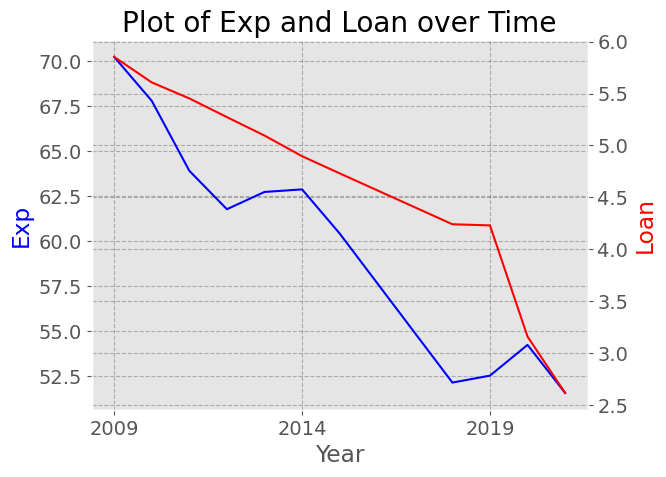

In [9]:
subset_df = df[df['mun'] == 'All Denmark']

# convert 'year' to numeric data type
subset_df['year'] = pd.to_numeric(subset_df['year'])

fig, ax1 = plt.subplots()

# plot 'exp' on the first axis
ax1.plot(subset_df['year'], subset_df['exp_per_cap'], color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Exp', color='b')

# create a twin axis
ax2 = ax1.twinx()

# plot 'loan' on the second axis
ax2.plot(subset_df['year'], subset_df['loan_per_cap'], color='r')
ax2.set_ylabel('Loan', color='r')

# set tick locations and labels for x-axis
xticks = np.arange(subset_df['year'].min(), subset_df['year'].max()+1, 5)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)

plt.title('Plot of Exp and Loan over Time')
plt.show()


The plot displays data for Denmark on the expenditure per capita on libary material and loan of books per capita. Both variables exhibit a decreasing trend over the period studied, indicating that Denmarks is spending less on books and lending fewer books per capita over time. However, it's not possible to determine whether the decrease in expenditure per capita on library material and books caused the decrease in loaned books per capita, or vice versa. Nonetheless, it's reasonable to expect that the decrease in expenditure caused the decrease in loaned books, since libraries with less funding may have fewer resources to purchase books and promote reading.

### 2.2. <a id='toc2_2_'></a>[Relation between books per capita and expenditure per capita](#toc0_)

**Scatter plot**

We now plot the relationship between the expenditure and the number of borrowed books in muisipalities

In [10]:
#Deleting the Regions and the All of Denmark observations, so as not to count observations twice.
#Deleting municipalities with no expenditure for matirial
df_mun = df[~df['mun'].str.startswith(('Region','All Denmark'))]
df_2 = df=df_mun[df_mun['exp_per_cap'] > 1]


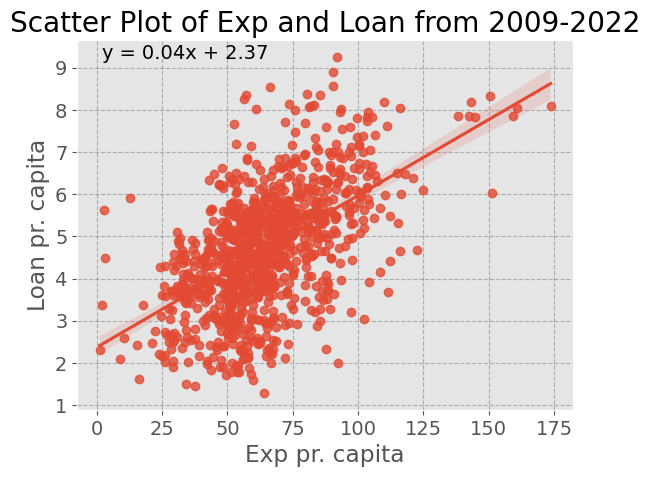

                            OLS Regression Results                            
Dep. Variable:           loan_per_cap   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     428.4
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           2.47e-79
Time:                        14:24:55   Log-Likelihood:                -1575.6
No. Observations:                 990   AIC:                             3155.
Df Residuals:                     988   BIC:                             3165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3716      0.118     20.044      

In [23]:

subset_df = df_2 #[df['year'] == 'YYYY']

# create a scatter plot with 'exp' on the x-axis and 'loan' on the y-axis
ax = sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df)

# set plot title and labels
plt.title('Scatter Plot of Exp and Loan from 2009-2022')
plt.xlabel('Exp pr. capita')
plt.ylabel('Loan pr. capita')

# add regression equation
slope, intercept = np.polyfit(subset_df['exp_per_cap'], subset_df['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')

# display the plot
plt.show()


subset_df = df_2 #[df['year'] == 'YYYY']

# create a regression model with 'exp_per_cap' and 'Loan_per_cap'
X = subset_df[['exp_per_cap']]
y = subset_df['loan_per_cap']
X = sm.add_constant(X)
model1 = sm.OLS(y, X).fit()
print(model1.summary())



The table presents the OLS estimate for the linear regression model between expenditure on material per capita, and the number of books borrowed per capita. 

The table shows a positive and statistically significant estimate for the coefficient for the expenditure per capita. The coefficient is 0.0360, which suggests that for a one-unit increase in exp. per capita, the predicted loan of books per capita increases by 0.0360. If it was a causal relationship an increas in expenditure per capita of DKK 100  in a given municipalities would cause the average books borrowed per capita to increase by roughly 4 books, per year.





# Stop Her

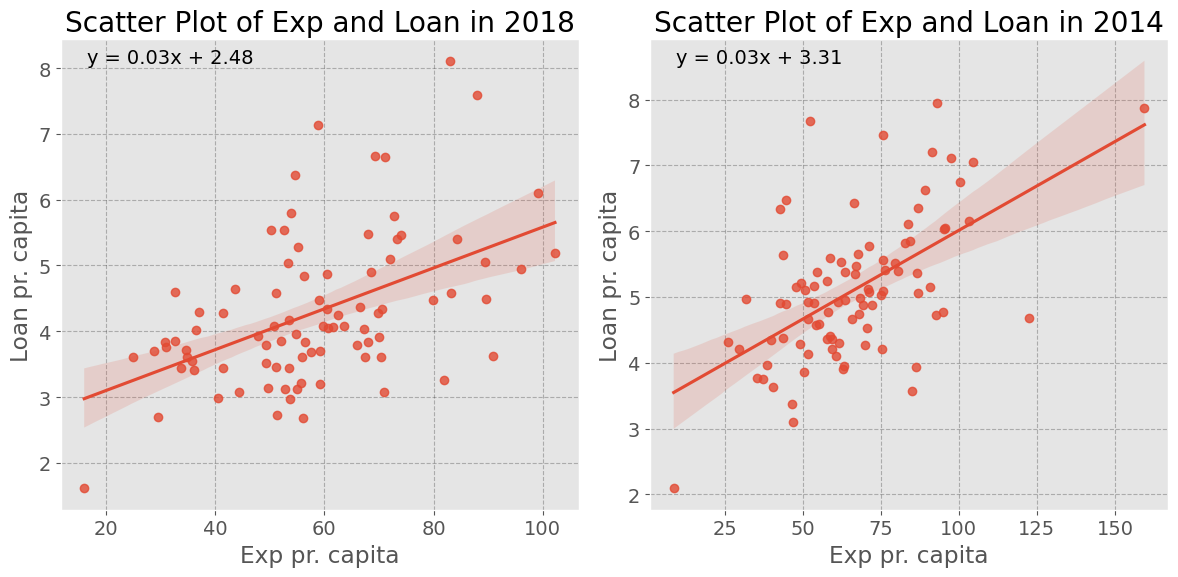

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot the first subplot
subset_df1 = df_2[df_2['year'] == '2018']
sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df1, ax=ax1)
slope, intercept = np.polyfit(subset_df1['exp_per_cap'], subset_df1['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax1.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')
ax1.set_title('Scatter Plot of Exp and Loan in 2018')
ax1.set_xlabel('Exp pr. capita')
ax1.set_ylabel('Loan pr. capita')

# plot the second subplot
subset_df2 = df_2[df_2['year'] == '2013']
sns.regplot(x='exp_per_cap', y='loan_per_cap', data=subset_df2, ax=ax2)
slope, intercept = np.polyfit(subset_df2['exp_per_cap'], subset_df2['loan_per_cap'], 1)
eq = f'y = {slope:.2f}x + {intercept:.2f}'
ax2.annotate(eq, xy=(0.05, 0.95), xycoords='axes fraction')
ax2.set_title('Scatter Plot of Exp and Loan in 2014')
ax2.set_xlabel('Exp pr. capita')
ax2.set_ylabel('Loan pr. capita')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()
